# Breast Cancer Predictions using Neural Networks Algorithms

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import math
#np.seterr(divide='ignore', invalid='ignore')

In [2]:
dataset = pd.read_csv('data.csv')
dataset = dataset.fillna(0)

In [3]:
dataset.head()

,id,diagnosis,texture_mean,area_mean,compactness_mean,texture_se,area_se,compactness_se,texture_worst,area_worst,compactness_worst
0,842302,M,10.38,1001.0,0.27760,0.9053,153.40,0.04904,17.33,2019.0,0.6656
1,842517,M,17.77,1326.0,0.07864,0.7339,74.08,0.01308,23.41,1956.0,0.1866
2,84300903,M,21.25,1203.0,0.15990,0.7869,94.03,0.04006,25.53,1709.0,0.4245
3,84348301,M,20.38,386.1,0.28390,1.1560,27.23,0.07458,26.50,567.7,0.8663
4,84358402,M,14.34,1297.0,0.13280,0.7813,94.44,0.02461,16.67,1575.0,0.2050


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060 entries, 0 to 1059
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1060 non-null   int64  
 1   diagnosis          1060 non-null   object 
 2   texture_mean       1060 non-null   float64
 3   area_mean          1060 non-null   float64
 4   compactness_mean   1060 non-null   float64
 5   texture_se         1060 non-null   float64
 6   area_se            1060 non-null   float64
 7   compactness_se     1060 non-null   float64
 8   texture_worst      1060 non-null   float64
 9   area_worst         1060 non-null   float64
 10  compactness_worst  1060 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 91.2+ KB


In [5]:
X = dataset.iloc[:,2:-1].values
y = dataset.iloc[:,1:2].values

In [6]:
from sklearn.preprocessing import LabelEncoder;
le =LabelEncoder();
y = le.fit_transform(y);
y=y.reshape(1060,1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


## Spliting Dataset for Training and Testing

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [9]:
def initialize_params(layer_dims):
    
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    params = {}
    np.random.seed(42)
    L = len(layer_dims)-1
    for l in range (L):
        params["W"+str(l+1)] = np.random.randn(layer_dims[l+1],layer_dims[l])*(2/layer_dims[l])**0.5
        params["b"+str(l+1)] = np.zeros((layer_dims[l+1],1))
    
    return params

## Forward Propagation

In [10]:
def Linear_forward(A,W,b):
    Z = np.dot(W,A)+b
    cache = (A,W,b)
    return Z,cache

In [11]:
def Activation_forward(A,W,b,Activation):
    if Activation == "relu":
        Z,Linear_cache = Linear_forward(A,W,b)
        A  = np.maximum(0,Z)
        A, activation_cache = A,Z
    elif Activation == 'sigmoid':
        Z,Linear_cache = Linear_forward(A,W,b)
        A,activation_cache = (1/(1+np.exp(-Z)),Z)
    cache= (Linear_cache,activation_cache)
    return A,cache

In [12]:
def forward_prop(X,params):
    A=X
    caches = []
    L = len(params)//2
    for l in range (L-1):
        A_prev = A
        A, cache = Activation_forward(A_prev,params["W"+str(l+1)],params["b"+str(l+1)],"relu")
        caches.append(cache)
    AL,cache = Activation_forward(A,params["W"+str(L)],params["b"+str(L)],"sigmoid")
    caches.append(cache)
    return AL,caches

In [13]:
def cost(AL,Y) :
    m = Y.shape[1]
    cost = -np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))/m
    return np.squeeze(cost)

## Backward Propagation

In [14]:
def linear_backward(dZ,cache):
    A_prev,W,b = cache
    m =A_prev.shape[1]
    dW = (np.dot(dZ,A_prev.T)/m) 
    db = np.sum(dZ,axis=1,keepdims=True)/m
    dA_prev = np.dot(W.T,dZ)
    return dA_prev , dW , db

In [15]:
def activation_backward(dA,cache,activation):
    linear_cache,activation_cache = cache
    Z=activation_cache
    if activation == "relu":
        dZ = (Z>0).astype(int)
        dZ = dA*dZ
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    elif activation == "sigmoid":
        dZ = np.multiply(dA,(1/(1+np.exp(-Z)))*(1-(1/(1+np.exp(-Z)))))
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    
    return dA_prev, dW, db

In [16]:
def backward_prop(AL,Y,caches):
    
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    grads = {}
    
    grads["dA"+str(L)] = -(np.divide(Y,AL)-np.divide(1-Y,1-AL))
    
    current_cache = caches[L-1]
    
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] =  activation_backward(grads["dA"+str(L)], current_cache, 'sigmoid')
    for l in reversed (range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp =  activation_backward(grads['dA'+str(l+1)], current_cache, 'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        
    return grads

In [17]:
def random_mini_batches(X, Y, mini_batch_size ):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    

    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(42)
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        
        mini_batch_X = shuffled_X[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k*mini_batch_size:(k+1)*mini_batch_size]
     
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        
        mini_batch_X = shuffled_X[:,num_complete_minibatches*mini_batch_size:m]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches*mini_batch_size:m]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [18]:
def initialize_adam(parameters) :
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
    
        v["dW" + str(l+1)] = np.zeros(parameters["W"+str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b"+str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters["W"+str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters["b"+str(l+1)].shape)
        
    
    return v, s

In [19]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
       
        v["dW" + str(l+1)] = beta1*v["dW"+str(l+1)]+(1-beta1)*grads["dW"+str(l+1)]
        v["db" + str(l+1)] = beta1*v["db"+str(l+1)]+(1-beta1)*grads["db"+str(l+1)]
       

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        
        v_corrected["dW" + str(l+1)] = v["dW"+str(l+1)]/(1-beta1**t)
        v_corrected["db" + str(l+1)] = v["db"+str(l+1)]/(1-beta1**t)
        
        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l+1)] = beta2*s["dW"+str(l+1)]+(1-beta2)*grads["dW"+str(l+1)]**2
        s["db" + str(l+1)] = beta2*s["db"+str(l+1)]+(1-beta2)*grads["db"+str(l+1)]**2


        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
     
        s_corrected["dW" + str(l+1)] = s["dW"+str(l+1)]/(1-beta2**t)
        s_corrected["db" + str(l+1)] = s["db"+str(l+1)]/(1-beta2**t)
        

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".

        parameters["W" + str(l+1)] = parameters["W"+str(l+1)] - learning_rate*(v_corrected["dW"+str(l+1)]/((s_corrected["dW"+str(l+1)]**0.5)+epsilon))
        parameters["b" + str(l+1)] = parameters["b"+str(l+1)] - learning_rate*(v_corrected["db"+str(l+1)]/((s_corrected["db"+str(l+1)]**0.5)+epsilon))
   

    return parameters, v, s

## Create the Model

In [20]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 16, beta = 0.9,beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 50, print_cost = True):
    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0  
    m =X.shape[1]
    
    params = initialize_params(layers_dims)
    
    v, s = initialize_adam(params)
    
    for i in range(num_epochs):
        minibatches = random_mini_batches(X, Y, mini_batch_size)
        cost_total = 0
        for minibatch in minibatches:
            
            (minibatch_X,minibatch_Y) = minibatch
            AL, caches = forward_prop(minibatch_X, params)
            
            cost_total += cost(AL, minibatch_Y)
            
            grads = backward_prop(AL, minibatch_Y, caches)
            t=t+1
            params, v, s = update_parameters_with_adam(params, grads, v, s, t, learning_rate, beta1, beta2,  epsilon)
            
        cost_avg = cost_total / m
            
        if print_cost and i %10 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        costs.append(cost_avg)
                
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return params

In [21]:
def predict(X,y,parameters):
    
    pre, cache = forward_prop(X,parameters)
    predictions = (pre>0.5).astype(int)
    from sklearn.metrics import accuracy_score
    
    print(accuracy_score(predictions[0],y[0]))
    return predictions


Cost after epoch 0: 0.044260
Cost after epoch 10: 0.041924
Cost after epoch 20: 0.039360
Cost after epoch 30: 0.036672
Cost after epoch 40: 0.034141


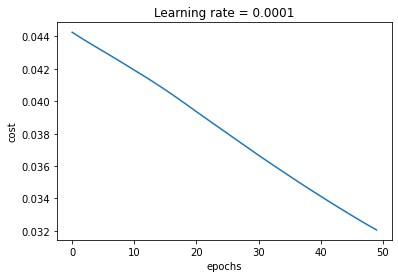

Train Accuracy:
0.6450704225352113
Test Accuracy:
0.6657142857142857
Cost after epoch 0: 0.044139
Cost after epoch 10: 0.039242
Cost after epoch 20: 0.033955
Cost after epoch 30: 0.029744
Cost after epoch 40: 0.026811


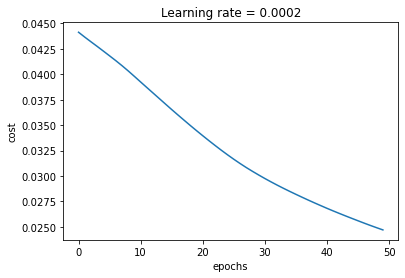

Train Accuracy:
0.8774647887323944
Test Accuracy:
0.88
Cost after epoch 0: 0.044021
Cost after epoch 10: 0.036405
Cost after epoch 20: 0.029618
Cost after epoch 30: 0.025493
Cost after epoch 40: 0.022524


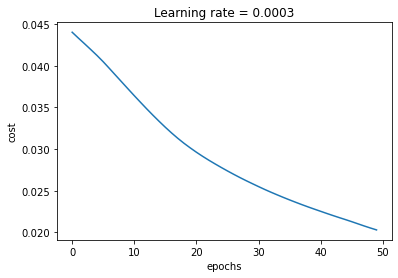

Train Accuracy:
0.9169014084507042
Test Accuracy:
0.9257142857142857
Cost after epoch 0: 0.043790
Cost after epoch 10: 0.031337
Cost after epoch 20: 0.024330
Cost after epoch 30: 0.020009
Cost after epoch 40: 0.016950


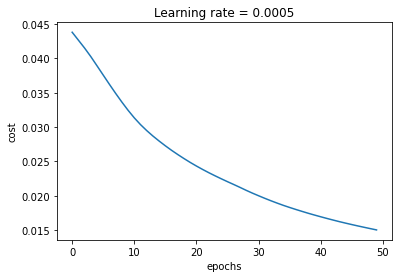

Train Accuracy:
0.9492957746478873
Test Accuracy:
0.9571428571428572
Cost after epoch 0: 0.043676
Cost after epoch 10: 0.029435
Cost after epoch 20: 0.022455
Cost after epoch 30: 0.017979
Cost after epoch 40: 0.015176


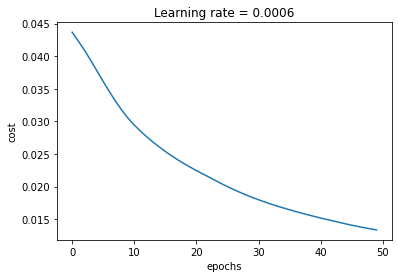

Train Accuracy:
0.9577464788732394
Test Accuracy:
0.9628571428571429
Cost after epoch 0: 0.043562
Cost after epoch 10: 0.027872
Cost after epoch 20: 0.020768
Cost after epoch 30: 0.016420
Cost after epoch 40: 0.013743


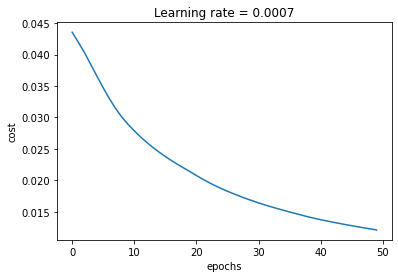

Train Accuracy:
0.9619718309859155
Test Accuracy:
0.9685714285714285
Cost after epoch 0: 0.043447
Cost after epoch 10: 0.026479
Cost after epoch 20: 0.019199
Cost after epoch 30: 0.015075
Cost after epoch 40: 0.012631


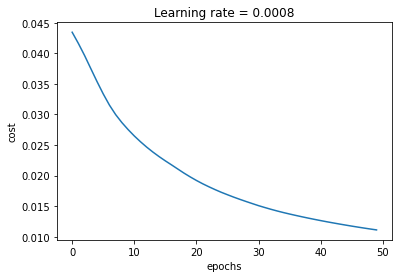

Train Accuracy:
0.9591549295774648
Test Accuracy:
0.9628571428571429
Cost after epoch 0: 0.043337
Cost after epoch 10: 0.025262
Cost after epoch 20: 0.017920
Cost after epoch 30: 0.014009
Cost after epoch 40: 0.011732


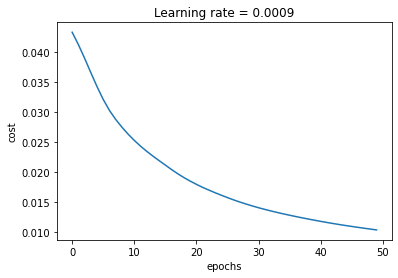

Train Accuracy:
0.9591549295774648
Test Accuracy:
0.9657142857142857
Cost after epoch 0: 0.043223
Cost after epoch 10: 0.024204
Cost after epoch 20: 0.016833
Cost after epoch 30: 0.013135
Cost after epoch 40: 0.010970


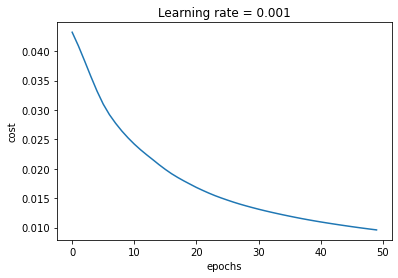

Train Accuracy:
0.9605633802816902
Test Accuracy:
0.9628571428571429


In [22]:
layers_dims = [X.shape[1],6,2,1]
lrates = [1e-4,2e-4,3e-4,5e-4,6e-4,7e-4,8e-4,9e-4,1e-3]
for lr in lrates:
    params = model(X_train.T, y_train.T ,layers_dims, optimizer = "adam",learning_rate=lr)
    print("Train Accuracy:")
    predictions_train = predict(X_train.T, y_train.T, params)
    print("Test Accuracy:")  
    predictions_test = predict(X_test.T, y_test.T, params)

Cost after epoch 0: 0.043280
Cost after epoch 10: 0.024729
Cost after epoch 20: 0.017395
Cost after epoch 30: 0.013568
Cost after epoch 40: 0.011330


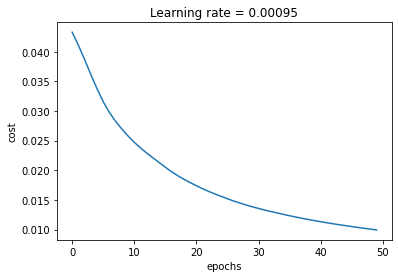

Accuracy
0.9657142857142857


In [23]:
parameters = model(X_train.T, y_train.T ,layers_dims=[X.shape[1],6,2,1], optimizer = "adam",learning_rate=0.00095)
print("Accuracy")
predictions = predict(X_test.T, y_test.T, parameters)

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.reshape(1,y_test.shape[0])[0],predictions[0])

array([[227,   6],
       [  6, 111]], dtype=int64)